# Week 2 – Classification
## Logistic Regression: From Intuition to Gradient Descent

In this notebook we will:

1. Motivate **classification** and compare it with linear regression.
2. Introduce the **logistic regression model**:
   $$
   f_{\vec{w}, b}(\vec{x}) = \sigma(\vec{w} \cdot \vec{x} + b)
   $$
3. Understand **decision boundaries**:
   - Linear boundaries in the original feature space.
   - Nonlinear boundaries via **feature transformations** (polynomial features).
4. Define the **logistic loss** and the **cost function**.
5. Derive and implement the **gradients** of the cost function.
6. Implement **gradient descent** and visualize **cost vs iterations**.

Notation (we keep it explicit and consistent):

- Vectors: $\vec{w}, \vec{x}$ (conceptual). In code they are NumPy arrays.
- Hypothesis (model): $f_{\vec{w}, b}(\vec{x})$.
- For sample $i$: $f_{\vec{w}, b}^{(i)}(\vec{x}^{(i)}) = f_{\vec{w}, b}(\vec{x}^{(i)})$.


In [ ]:
%pip install numpy matplotlib 

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

## Step 1 Load the Data set and binarice the dataset


### We have to Binarize the last column of the dataset, after that we have to sumarize the stats that we have, handle missing/outliers and finally we are goning to represent our by plots of the classes distribution

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


DATA PREPARATION
Target column 'Heart Disease' binarized: [1 0]
   Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   70    1                4  130          322             0            2   
1   67    0                3  115          564             0            2   
2   57    1                2  124          261             0            0   
3   64    1                4  128          263             0            0   
4   74    0                2  120          269             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     109                0            2.4            2   
1     160                0            1.6            2   
2     141                0            0.3            1   
3     105                1            0.2            2   
4     121                1            0.2            1   

   Number of vessels fluro  Thallium  Heart Disease  
0                        3         3              1  
1               

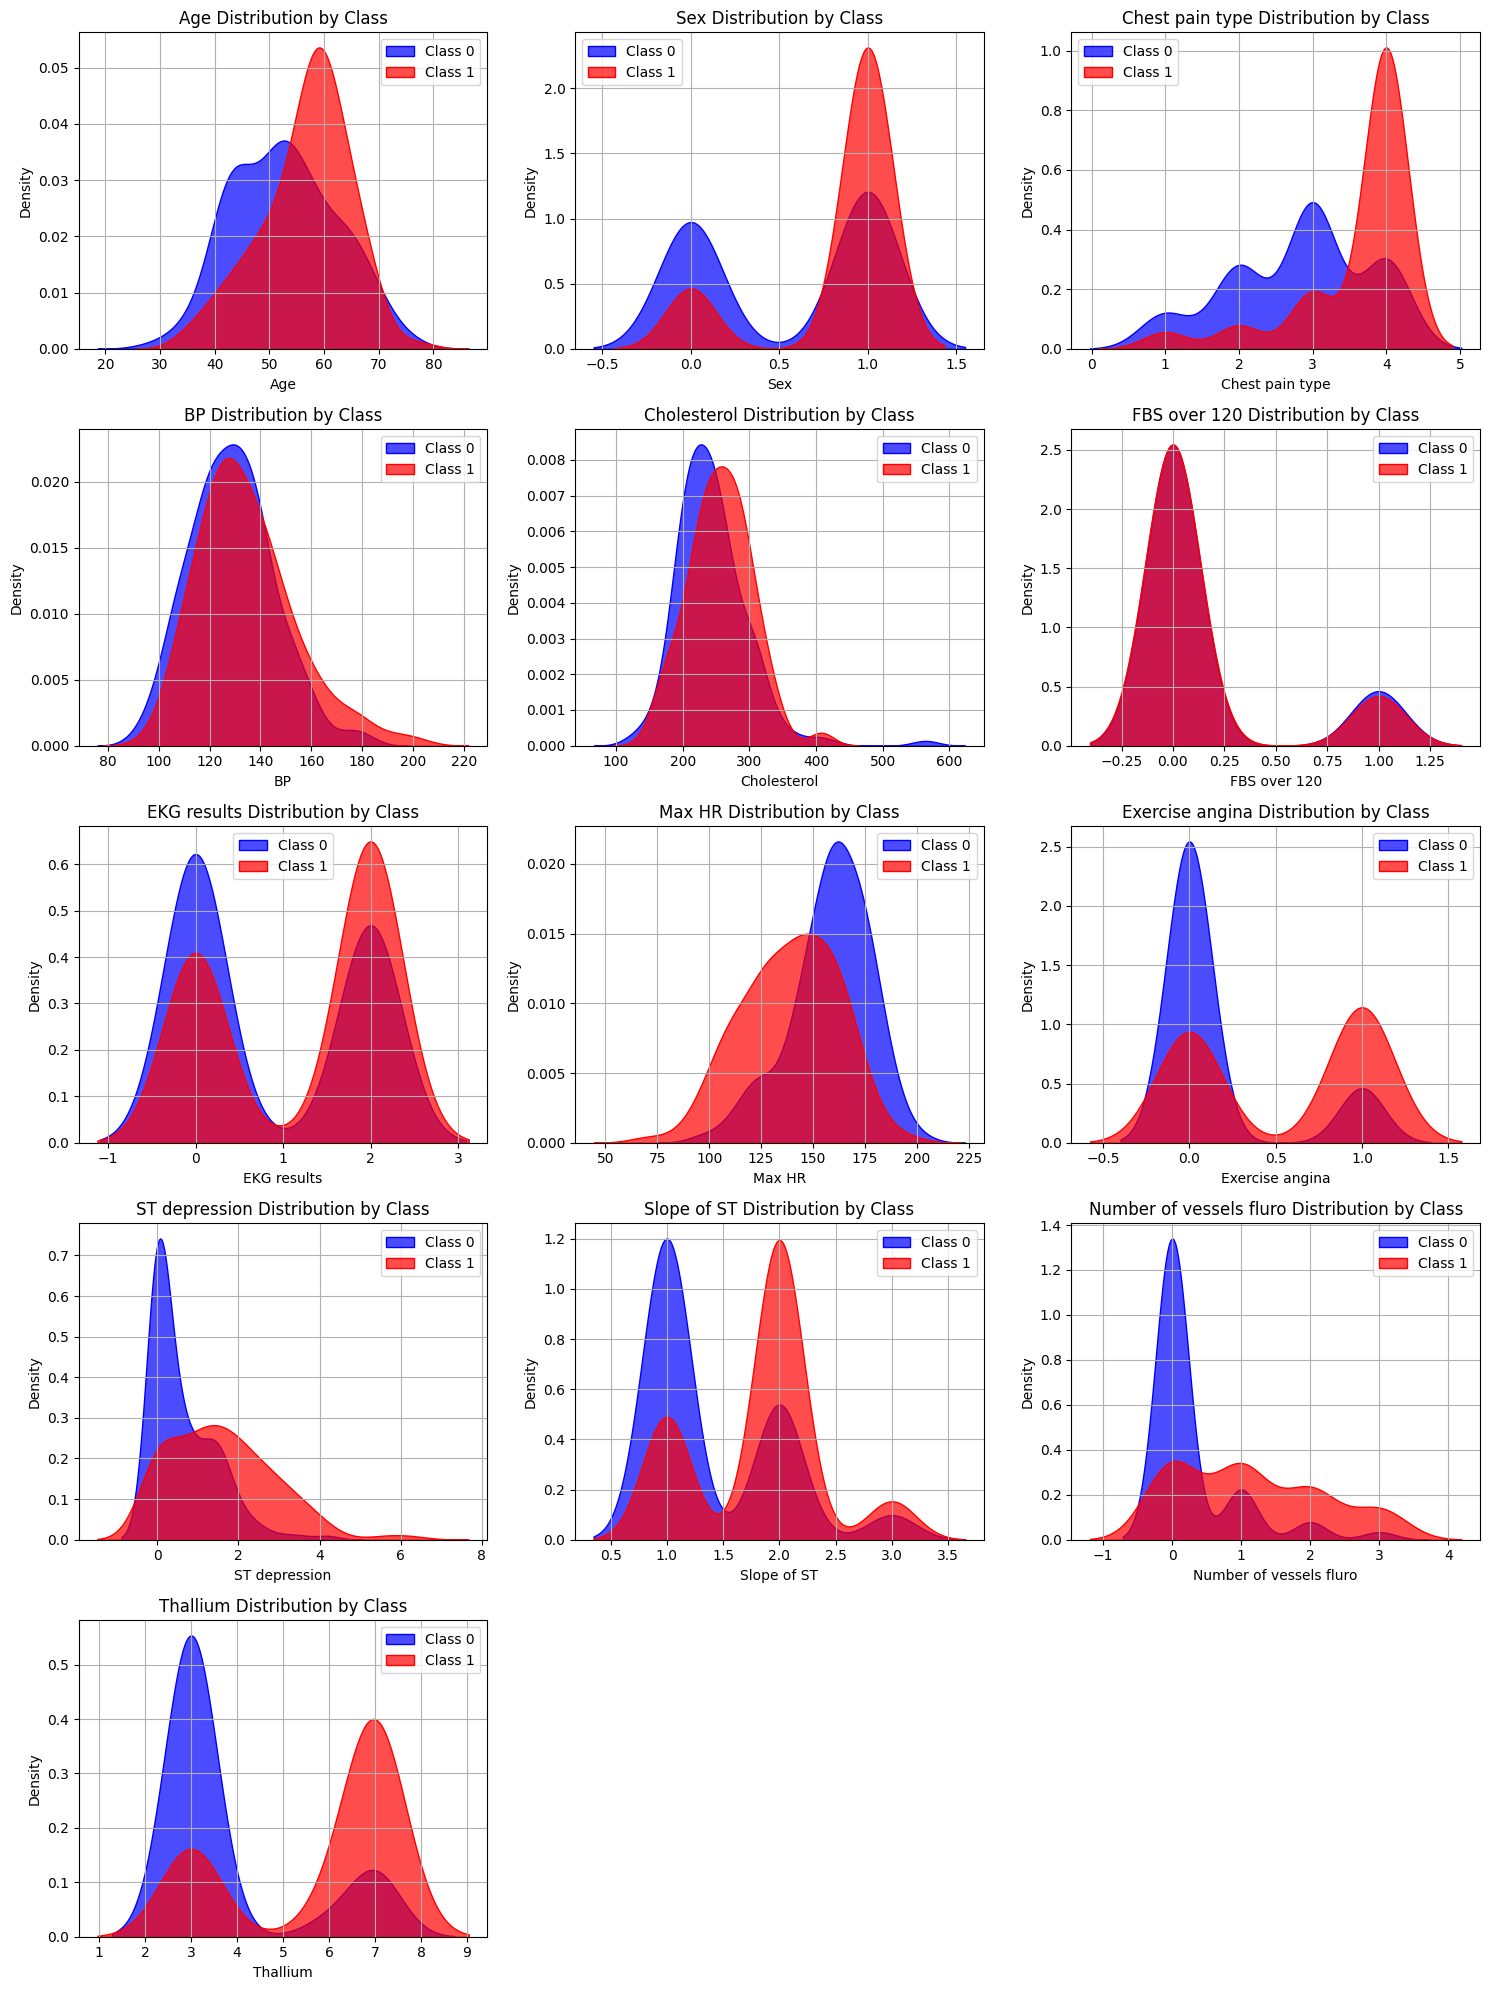

In [ ]:

%pip install seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Heart_Disease_Prediction.csv')
target_col = df.columns[-1]

print("="*60)
print("DATA PREPARATION")
print("="*60)

# Binarización
df[target_col] = df[target_col].map({
    'presence': 1, 'Presence': 1, 'PRESENCE': 1,
    'absence': 0, 'Absence': 0, 'ABSENCE': 0
})
print(f"Target column '{target_col}' binarized: {df[target_col].unique()}")
print(df.head())
print(f"\nDataset shape: {df.shape[0]} rows, {df.shape[1]} columns")


print("\n" + "="*60)
print("SUMMARIZE STATS")
print("="*60)

# 2. Tipos de datos
print("\n2. DATA TYPES:")
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"   {dtype}: {count} columns")

# 3. Estadísticas descriptivas para todas las columnas
print("\n3. DESCRIPTIVE STATISTICS (all columns):")

# Para columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    print("\n   Numerical columns statistics:")
    numeric_stats = df[numeric_cols].describe().T
    numeric_stats['range'] = numeric_stats['max'] - numeric_stats['min']
    numeric_stats['cv'] = (numeric_stats['std'] / numeric_stats['mean'] * 100).round(2)  # Coeficiente de variación
    print(numeric_stats[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'cv']].round(2))

# Para columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print("\n   Categorical columns summary:")
    for col in categorical_cols:
        unique_vals = df[col].nunique()
        top_value = df[col].value_counts().index[0] if len(df[col].value_counts()) > 0 else 'N/A'
        top_freq = df[col].value_counts().iloc[0] if len(df[col].value_counts()) > 0 else 0
        print(f"   {col}: {unique_vals} unique values, most common: '{top_value}' ({top_freq} times)")

# 4. Correlaciones
print("\n4. CORRELATIONS (numerical columns):")
if len(numeric_cols) > 1:
    corr_matrix = df[numeric_cols].corr()
    # Correlación con la variable target
    if target_col in numeric_cols:
        target_corr = corr_matrix[target_col].sort_values(ascending=False)
        print("\n   Correlation with target:")
        for col, corr in target_corr.items():
            if col != target_col:
                print(f"   {col}: {corr:.3f}")
    
    # Top correlaciones entre features
    print("\n   Top feature correlations (absolute):")
    corr_series = corr_matrix.unstack()
    corr_series = corr_series[corr_series.index.get_level_values(0) != corr_series.index.get_level_values(1)]
    corr_series = corr_series.abs().sort_values(ascending=False)
    top_corrs = corr_series.head(5)
    for idx, value in top_corrs.items():
        print(f"   {idx[0]} - {idx[1]}: {df.corr().loc[idx[0], idx[1]]:.3f}")

# 5. Distribución de la variable target
print("\n5. TARGET DISTRIBUTION:")
class_counts = df[target_col].value_counts()
class_percent = df[target_col].value_counts(normalize=True) * 100
for cls, (count, percent) in enumerate(zip(class_counts, class_percent)):
    print(f"   Class {cls}: {count} samples ({percent:.1f}%)")
print(f"   Balance ratio: {min(class_counts)/max(class_counts):.3f}")

print("\n" + "="*60)
print("MISSING VALUES")
print("="*60)
missing = df.isnull().sum()
if missing.sum() == 0:
    print("No missing values found")
else:
    print(f"Found {missing.sum()} missing values")
    for col in df.columns[df.isnull().any()]:
        missing_pct = (df[col].isnull().sum() / len(df)) * 100
        print(f"   {col}: {df[col].isnull().sum()} ({missing_pct:.1f}%)")
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
            print(f"     → Imputed with median: {df[col].median():.2f}")
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)
            print(f"     → Imputed with mode: '{df[col].mode()[0]}'")

print("\n" + "="*60)
print("CLASS DISTRIBUTION")
print("="*60)
print(f"Class 0: {class_counts[0]} samples ({class_counts[0]/len(df)*100:.1f}%)")
print(f"Class 1: {class_counts[1]} samples ({class_counts[1]/len(df)*100:.1f}%)")

print("\n" + "="*60)
print("VISUALIZING ALL COLUMNS")
print("="*60)

n_cols = len(df.columns) - 1
n_rows = (n_cols + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(df.columns):
    if col == target_col:
        continue
    
    ax = axes[idx]
    
    if df[col].dtype in ['int64', 'float64']:
        for class_val, color in zip([0, 1], ['blue', 'red']):
            subset = df[df[target_col] == class_val][col].dropna()
            if len(subset) > 1:
                sns.kdeplot(subset, ax=ax, label=f'Class {class_val}', 
                          color=color, alpha=0.7, fill=True)
        ax.set_title(f'{col} Distribution by Class')
        ax.set_xlabel(col)
        ax.set_ylabel('Density')
        ax.legend()
    else:
        cross_tab = pd.crosstab(df[col], df[target_col])
        cross_tab.plot(kind='bar', stacked=True, ax=ax, 
                      color=['blue', 'red'], alpha=0.7)
        ax.set_title(f'{col} by Class')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.legend(['Class 0', 'Class 1'])
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

for idx in range(n_cols, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()




## For the 70/30 slit of the rows that we need we are going to divide it like this:

In [ ]:
print("DATA PREPARATION: SPLIT & NORMALIZATION")

selected_features = ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120']
available_features = [f for f in selected_features if f in df.columns]

if len(available_features) < 6:
    extra_features = ['Max HR', 'ST depression', 'Exercise angina', 'Slope of ST', 'Number of vessels fluro']
    for feat in extra_features:
        if feat in df.columns and feat not in available_features and len(available_features) < 6:
            available_features.append(feat)

print(f"Selected {len(available_features)} features: {available_features}")

X = df[available_features]
y = df[target_col]

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

print(f"\nTrain size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nClass distribution - Full: {y.value_counts(normalize=True).values}")
print(f"Class distribution - Train: {y_train.value_counts(normalize=True).values}")
print(f"Class distribution - Test: {y_test.value_counts(normalize=True).values}")

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features to normalize: {numeric_features}")
print(f"Categorical features: {categorical_features}")

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

if len(categorical_features) > 0:
    ohe = preprocessor.named_transformers_['cat']
    cat_feature_names = ohe.get_feature_names_out(categorical_features)
    all_feature_names = numeric_features + list(cat_feature_names)
else:
    all_feature_names = numeric_features

print(f"\nOriginal features: {len(available_features)}")
print(f"Processed features: {len(all_feature_names)}")

X_train_df = pd.DataFrame(X_train_processed, columns=all_feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=all_feature_names, index=X_test.index)

print(f"\nX_train processed shape: {X_train_df.shape}")
print(f"X_test processed shape: {X_test_df.shape}")

print("\nNormalization check (train set means should be ~0, std ~1):")
for feat in numeric_features:
    mean_val = X_train_df[feat].mean()
    std_val = X_train_df[feat].std()
    print(f"  {feat}: mean={mean_val:.4f}, std={std_val:.4f}")

print("\n" + "="*60)
print("PREPARATION COMPLETED")


: 

## Step 2. Implement Basic Logistic Regression

### Sigmoid Function

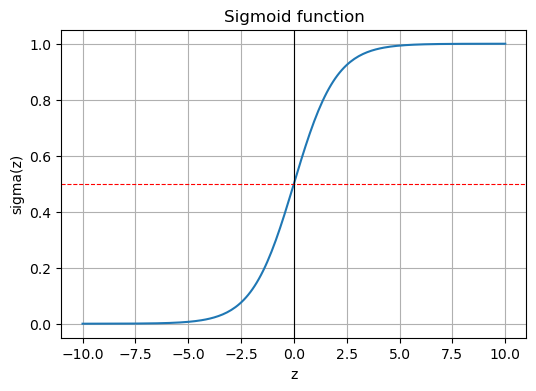

In [31]:
def sigmoid(z):
    """Compute the sigmoid of z."""
    return 1 / (1 + np.exp(-z))


# Visualize the sigmoid function
z_values = np.linspace(-10, 10, 200)
sig_values = sigmoid(z_values)

plt.figure()
plt.plot(z_values, sig_values)
plt.title("Sigmoid function")
plt.xlabel("z")
plt.ylabel("sigma(z)")
plt.ylim(-0.05, 1.05)
plt.axhline(0.5, color="red", linestyle="--", linewidth=0.8)
plt.axvline(0, color="black", linewidth=0.8)
plt.show()

### Cost Binary Entropy

In [7]:
def compute_cost(w, b, X, y):
    m, n = X.shape
    z = X @ w + b
    f = sigmoid(z)
    eps = 1e-8
    f_clipped = np.clip(f, eps, 1 - eps)
    J = -(1 / m) * np.sum(
        y * np.log(f_clipped) + (1 - y) * np.log(1 - f_clipped)
    )
    return J

### Gradient Function


In [8]:
def compute_gradient(w, b, X, y):
    m, n = X.shape
    z = X @ w + b
    f = sigmoid(z)
    error = f - y
    dj_dw = (1 / m) * (X.T @ error)
    dj_db = (1 / m) * np.sum(error)
    return dj_dw, dj_db

### Gradient Decent

In [9]:
def gradient_descent(X, y, w_init, b_init, alpha, num_iters):
    w = w_init.copy()
    b = b_init
    J_history = []
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(w, b, X, y)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        J = compute_cost(w, b, X, y)
        J_history.append(J)
    return w, b, J_history

### Prediction function

In [10]:
def calculate_z(X, w, b):
    return X @ w + b

def predict(X, w, b, threshold=0.5):
    z = calculate_z(X, w, b)
    pred = sigmoid(z)
    return pred >= threshold

### Metrics Calculation

In [11]:
def calculateParameters(y_true, y_pred):
    TP = np.sum((y_true == 1.0) & (y_pred == 1.0))
    TN = np.sum((y_true == 0.0) & (y_pred == 0.0))
    FP = np.sum((y_true == 0.0) & (y_pred == 1.0))
    FN = np.sum((y_true == 1.0) & (y_pred == 0.0))
    return TP, TN, FP, FN

### Training Setup

In [ ]:
w0 = np.zeros(X_train.shape[1])
b0 = 0.0
alpha = 0.01
num_iters = 2000
w_trained, b_trained, J_hist = gradient_descent(X_train, y_train, w0, b0, alpha, num_iters)

NameError: name 'X_train' is not defined

### Plot Cost


In [ ]:
plt.figure()
plt.plot(J_hist)
plt.xlabel("Iteration")
plt.ylabel("J(w,b)")
plt.show()

### Calculate Metrics


In [ ]:
Y_pred_train = predict(X_train, w_trained, b_trained)
Y_pred_test = predict(X_test, w_trained, b_trained)
TP_train, TN_train, FP_train, FN_train = calculateParameters(y_train, Y_pred_train)
TP_test, TN_test, FP_test, FN_test = calculateParameters(y_test, Y_pred_test)
accuracy_train = (TP_train + TN_train) / (TP_train + TN_train + FP_train + FN_train)
accuracy_test = (TP_test + TN_test) / (TP_test + TN_test + FP_test + FN_test)
precision_train = TP_train / (TP_train + FP_train)
precision_test = TP_test / (TP_test + FP_test)
recall_train = TP_train / (TP_train + FN_train)
recall_test = TP_test / (TP_test + FN_test)
f1_score_train = 2 * ((precision_train * recall_train) / (precision_train + recall_train))
f1_score_test = 2 * ((precision_test * recall_test) / (precision_test + recall_test))

## Step 3

###  Plot Boundary Function

In [ ]:
def plot_boundary_and_scatter(X, y, w, b, title, feature_names):
    plt.figure()
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c="tab:blue", label="No disease", alpha=0.7)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c="tab:red", label="Disease", alpha=0.7)
    x1_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
    if abs(w[1]) < 1e-8:
        x1_line = -b / (w[0] + 1e-8)
        plt.axvline(x=x1_line, color="k", linestyle="--", label="Decision boundary")
    else:
        x2_vals = -(w[0] * x1_vals + b) / w[1]
        plt.plot(x1_vals, x2_vals, "k--", label="Decision boundary")
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.legend()
    plt.show()

### Age-Cholesterol

In [ ]:
x_age_cholesterol = X_train[:, [0, 1]]
y_age_cholesterol = y_train
x_age_cholesterol_mean = x_age_cholesterol.mean(axis=0)
x_age_cholesterol_std = x_age_cholesterol.std(axis=0) + 1e-8
x_age_cholesterol = (x_age_cholesterol - x_age_cholesterol_mean) / x_age_cholesterol_std
w_age_cholesterol = np.zeros(2)
b_age_cholesterol = 0.0
w_age_trained, b_age_trained, J_hist_age = gradient_descent(x_age_cholesterol, y_age_cholesterol, w_age_cholesterol, b_age_cholesterol, 0.01, 2000)
plot_boundary_and_scatter(x_age_cholesterol, y_age_cholesterol, w_age_trained, b_age_trained, "Age vs Cholesterol", ["Age", "Cholesterol"])

### BP-Max HR

In [ ]:
x_bp_maxHr = X_train[:, [2, 3]]
y_bp_maxHr = y_train
x_bp_maxHr_mean = x_bp_maxHr.mean(axis=0)
x_bp_maxHr_std = x_bp_maxHr.std(axis=0) + 1e-8
x_bp_maxHr = (x_bp_maxHr - x_bp_maxHr_mean) / x_bp_maxHr_std
w_bp_maxHr = np.zeros(2)
b_bp_maxHr = 0.0
w_bp_maxHr, b_bp_maxHr, J_hist_bp = gradient_descent(x_bp_maxHr, y_bp_maxHr, w_bp_maxHr, b_bp_maxHr, 0.01, 2000)
plot_boundary_and_scatter(x_bp_maxHr, y_bp_maxHr, w_bp_maxHr, b_bp_maxHr, "BP vs Max HR", ["BP", "Max HR"])

### ST Depression-Vessels

In [ ]:
x_st_vessels = X_train[:, [4, 5]]
y_st_vessels = y_train
x_st_vessels_mean = x_st_vessels.mean(axis=0)
x_st_vessels_std = x_st_vessels.std(axis=0) + 1e-8
x_st_vessels = (x_st_vessels - x_st_vessels_mean) / x_st_vessels_std
w_st_vessels_init = np.zeros(2)
b_st_vessels_init = 0.0
w_st_vessels, b_st_vessels, J_hist_st = gradient_descent(x_st_vessels, y_st_vessels, w_st_vessels_init, b_st_vessels_init, 0.01, 2000)
plot_boundary_and_scatter(x_st_vessels, y_st_vessels, w_st_vessels, b_st_vessels, "ST Depression vs Vessels", ["ST depression", "Number of vessels fluro"])

## Step 4

### Regularized Cost Function

In [ ]:
def compute_cost_log_reg_reg(w, b, X, y, lam):
    m, n = X.shape
    z = X @ w + b
    f = sigmoid(z)
    eps = 1e-8
    f_clipped = np.clip(f, eps, 1 - eps)
    ce = - (1 / m) * np.sum(
        y * np.log(f_clipped) + (1 - y) * np.log(1 - f_clipped)
    )
    reg = (lam / (2*m)) * np.sum(w ** 2)
    return ce + reg

### Regularized Gradient Function

In [ ]:
def compute_gradient_log_reg_reg(w, b, X, y, lam):
    m, n = X.shape
    z = X @ w + b
    f = sigmoid(z)
    error = f - y
    dj_dw = (1 / m) * (X.T @ error) + (lam / m) * w
    dj_db = (1 / m) * np.sum(error)
    return dj_dw, dj_db

### Regularized Gradient Descent

In [ ]:
def gradient_descent_log_reg_reg(X, y, w_init, b_init, alpha, lam, num_iters):
    w = w_init.copy()
    b = b_init
    J_history = []
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient_log_reg_reg(w, b, X, y, lam)
        w -= alpha * dj_dw
        b -= alpha * dj_db
        J_history.append(compute_cost_log_reg_reg(w, b, X, y, lam))
    return w, b, J_history

### Tune Lambda

In [ ]:
lambdas = [0, 0.001, 0.01, 0.1, 1]
results = []
for lam in lambdas:
    w0 = np.zeros(X_train.shape[1])
    b0 = 0.0
    w_reg, b_reg, J_hist = gradient_descent_log_reg_reg(X_train, y_train, w0, b0, 0.01, lam, 2000)
    y_pred_train = predict(X_train, w_reg, b_reg)
    y_pred_test = predict(X_test, w_reg, b_reg)
    TP_train_reg, TN_train_reg, FP_train_reg, FN_train_reg = calculateParameters(y_train, y_pred_train)
    TP_test_reg, TN_test_reg, FP_test_reg, FN_test_reg = calculateParameters(y_test, y_pred_test)
    acc_train = (TP_train_reg + TN_train_reg) / (TP_train_reg + TN_train_reg + FP_train_reg + FN_train_reg)
    acc_test = (TP_test_reg + TN_test_reg) / (TP_test_reg + TN_test_reg + FP_test_reg + FN_test_reg)
    weight_norm = float(np.linalg.norm(w_reg))
    results.append({'lambda': lam, 'train_acc': acc_train, 'test_acc': acc_test, 'weight_norm': weight_norm})

### Regularized Decision Boundary Plot

In [ ]:
def plot_decision_boundary_logreg(w, b, X, y, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    z = grid @ w + b
    probs = sigmoid(z).reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.2, colors=["tab:blue", "tab:orange"])
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="y = 0")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="y = 1")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()

### Compare Unregularized vs Regularized

In [ ]:
X_pair = X_train[:, [2, 3]]
y_pair = y_train
w0 = np.zeros(2)
b0 = 0.0
w_unreg, b_unreg, J_unreg = gradient_descent(X_pair, y_pair, w0, b0, 0.01, 2000)
lam = 0.1
w_reg, b_reg, J_reg = gradient_descent_log_reg_reg(X_pair, y_pair, w0, b0, 0.01, lam, 2000)
plot_decision_boundary_logreg(w_unreg, b_unreg, X_pair, y_pair, "BP vs Max HR (lambda=0)")
plot_decision_boundary_logreg(w_reg, b_reg, X_pair, y_pair, f"BP vs Max HR (lambda={lam})")